# Simulation and Performance Evaluation - Homework 4

### University of Trento - A.Y. 2019 / 2020

Lotito Quintino Francesco - 215032

Zanella Davide - 211463

---

**Important:** we delivered two files, a .ipynb file (jupyter notebook) and a .html file (export of the notebook), if the .ipynb file is run we expect the datasets to be in the same directory of this notebook in order to be read as input.

## Exercise 1

Let's start defining the different types of event that we will use.

In [1]:
from enum import Enum

class EventTypes(Enum):
    start_simulation = 0,
    end_simulation = 1,
    packet_arrival = 2,
    packet_departure = 3,
    debug = 4

The following is the class representing an event. Its properties are the occurrence time, the type of the event and the pointer to the next occurring event.

In [2]:
class Event:
    def __init__(self, occ_time, event_type:EventTypes):
        self.occurrence_time = occ_time
        self.event_type = event_type
        self.next_event = None

Now, we need a class representing the Queue. It has a property pointing to the first event of the queue.
It's defined a method to insert an event in the queue linking it between the two events occurring immediatly before and after the event we are inserting.
There is a useful method to print the whole queue following the links between the events.
The last method of the Queue class extracts the first element of the queue removing it from the queue.

In [3]:
class Queue:
    def __init__(self):
        self.first_event = None


    def insert_event(self, event:Event):
        if event.occurrence_time < self.first_event.occurrence_time:
            event.next_event = self.first_event
            self.first_event = event
        else:
            curr_event = self.first_event
            while curr_event.next_event is not None and \
                    event.occurrence_time > curr_event.next_event.occurrence_time:
                curr_event = curr_event.next_event

            event.next_event = curr_event.next_event
            curr_event.next_event = event


    def print(self):
        curr_event = self.first_event
        while curr_event is not None:
            print("->", curr_event.occurrence_time, curr_event.event_type)
            curr_event = curr_event.next_event


    def pop(self):
        if self.first_event is None:
            return None

        curr_event = self.first_event
        self.first_event = self.first_event.next_event

        return curr_event

To be certain that the previous code works properly let's give it a try creating the start and end of a simulation events,
adding them to the Queue and print its content.

In [4]:
queue = Queue()
curr_time = 0
max_time = 1000

start_event = Event(curr_time, EventTypes.start_simulation)
end_event = Event(max_time, EventTypes.end_simulation)

queue.first_event = start_event
queue.insert_event(end_event)

queue.print()

-> 0 EventTypes.start_simulation
-> 1000 EventTypes.end_simulation


We can even try adding some events not ordered and check that queue automatically put them in the correct order while inserting them.

In [5]:
events = [
    Event(100, EventTypes.packet_departure),
    Event(-50, EventTypes.packet_arrival),
    Event(842, EventTypes.packet_departure),
    Event(684, EventTypes.packet_arrival),
    Event(354, EventTypes.packet_arrival),
    Event(956, EventTypes.packet_departure),
    Event(715, EventTypes.debug),
    Event(20, EventTypes.packet_arrival),
    Event(953, EventTypes.packet_departure)
]

for e in events:
    queue.insert_event(e)

queue.print()

-> -50 EventTypes.packet_arrival
-> 0 EventTypes.start_simulation
-> 20 EventTypes.packet_arrival
-> 100 EventTypes.packet_departure
-> 354 EventTypes.packet_arrival
-> 684 EventTypes.packet_arrival
-> 715 EventTypes.debug
-> 842 EventTypes.packet_departure
-> 953 EventTypes.packet_departure
-> 956 EventTypes.packet_departure
-> 1000 EventTypes.end_simulation


Now, we need a class for the server. Every server should have a queue of the packets to be processed and a status, meaning if the server is busy (`1`) or free (`0`).

In [6]:
class Server:
    def __init__(self):
        self.server_status = 0  # 0 means available, 1 means busy
        self.queue = []

The following code is a skeleton of the workflow adopted to manage a queue of events.

In [7]:
while True:
    event = queue.pop()
    if event is None:
        continue
    if event.event_type == EventTypes.start_simulation:
        print("start simulation")
    elif event.event_type == EventTypes.packet_arrival:
        print("packet arrival")
    elif event.event_type == EventTypes.packet_departure:
        print("packet departure")
    elif event.event_type == EventTypes.debug:
        print("debug")
    elif event.event_type == EventTypes.end_simulation:
        print("end simulation")
        break

packet arrival
start simulation
packet arrival
packet departure
packet arrival
packet arrival
debug
packet departure
packet departure
packet departure
end simulation


Let's define two functions. The first one simply extract a number from an exponential distribution given the lambda parameter.
The second one simulates the arrival of some packets to our server using the first function to decide the inter-arrival time.

In [8]:
import random as rnd

def exponential_val(lambda_val):
    return rnd.expovariate(lambda_val)


def simulate(arr_val, max_time):
    curr_time = 0
    queue = Queue()

    arrival_time = exponential_val(arr_val)
    curr_time += arrival_time

    queue.first_event = Event(curr_time, EventTypes.start_simulation)

    while curr_time < max_time:
        arrival_time = exponential_val(arr_val)
        curr_time += arrival_time

        if curr_time >= max_time:
            e = Event(curr_time, EventTypes.end_simulation)
        else:
            e = Event(curr_time, EventTypes.packet_arrival)

        queue.insert_event(e)

    return queue

The following function is an evolution of the skeleton defined before, managing the arrival of a packet and scheduling its departure sampling from the exponential distribution.

In [9]:
def manage_packets(q, server, server_lambda):
    packet_time = []
    packet_status = []
    delay_in_queue = []
    while True:
        event = q.pop()
        if event.event_type == EventTypes.start_simulation:
            pass
        elif event.event_type == EventTypes.packet_arrival:
            if server.server_status == 0:  # server free
                server.server_status = 1
                leave_int = exponential_val(server_lambda)
                e = Event(event.occurrence_time + leave_int, EventTypes.packet_departure)
                q.insert_event(e)
            else:  # server busy
                server.queue.append(event)
        elif event.event_type == EventTypes.packet_departure:
            if len(server.queue) == 0:
                server.server_status = 0
            else:  # schedule next departure event
                leave_int = exponential_val(server_lambda)
                e = Event(event.occurrence_time + leave_int, EventTypes.packet_departure)
                q.insert_event(e)

                delay_in_queue.append(e.occurrence_time - server.queue[0].occurrence_time)
                server.queue = server.queue[1:]  # remove first packet from the queue
        elif event.event_type == EventTypes.debug:
            print("debug")
        elif event.event_type == EventTypes.end_simulation:
            break

        if len(packet_time) and event.occurrence_time < packet_time[-1]:
            print(event.occurrence_time, event.event_type)
            print(packet_time[-1])

        packet_time.append(event.occurrence_time)
        num_packets = len(server.queue) + server.server_status
        packet_status.append(num_packets)

    return packet_time, packet_status, delay_in_queue

The following is a useful function that uses the functions defined previously.
It simulates the arrival and the departure of some packets and then plots the number of packets in the system comparing it with the theoretical average value.

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_simulation(lmbda, mu, max_time):
    q = simulate(lmbda, max_time)
    s = Server()
    packet_time, packet_status, _ = manage_packets(q, s, mu)

    plt.plot(packet_time, packet_status)

    p = lmbda / mu
    theory_val = p/(1-p)
    theoretical = [theory_val] * len(packet_time)

    plt.plot(packet_time, theoretical)

    plt.xlabel('Time in seconds')
    plt.ylabel('Number of packets in the system')
    plt.legend(['simulated values', 'theoretical value'])
    plt.title('Number of packets in the system - lambda: {} mu: {}'.format(lmbda, mu))

    plt.show()

As can be seen from the following plots, keeping constant the parameter for the exponential random variable of the serving time, the growth of the lambda for the inter-arrival time, the more the number of packets in the system.

When the lambda is too high with respect to the mu, the growth of the number of packets in the system is linear.
This means that the server takes too much time to manage a packet, but some new packets are generated in the meantime.

The theoretical average number of packets in the system can be taken as valid only when the system is in stationary conditions.
If $\lambda > \mu$ we cannot have stationary conditions: too many packets arrive to the server.

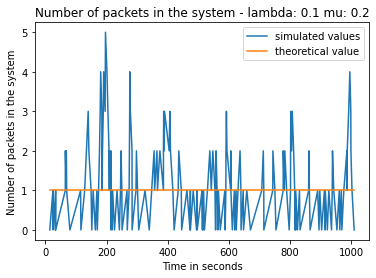

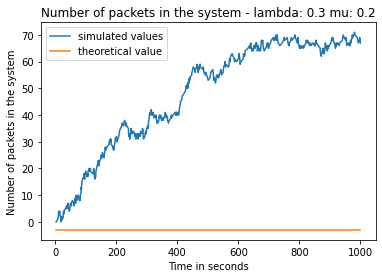

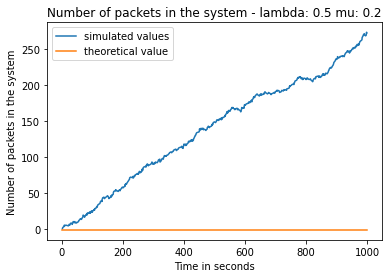

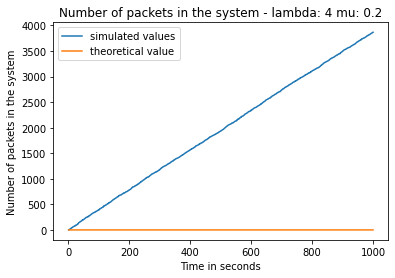

In [11]:
plot_simulation(0.1, 0.2, 1000)
plot_simulation(0.3, 0.2, 1000)
plot_simulation(0.5, 0.2, 1000)
plot_simulation(4, 0.2, 1000)

When $\lambda < \mu$, as said before, the system is in stationary conditions and the server is able to manage all the packets as confirmed by the following plots.

Now, the theoretical values are more or less in the middle of the graph summarizing correctly the state of the system.

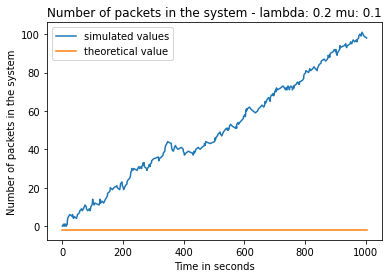

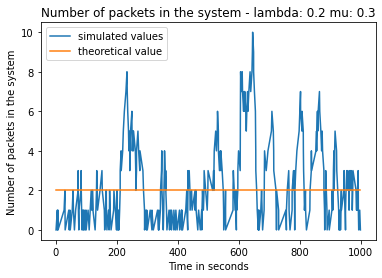

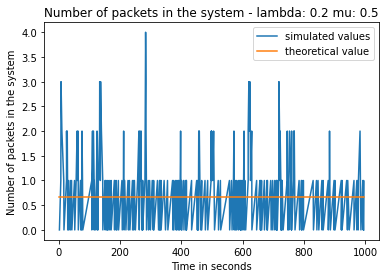

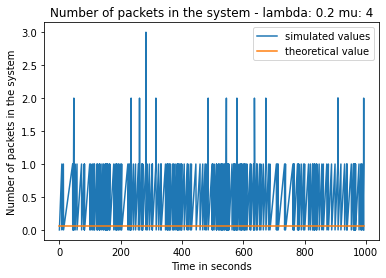

In [12]:
plot_simulation(0.2, 0.1, 1000)
plot_simulation(0.2, 0.3, 1000)
plot_simulation(0.2, 0.5, 1000)
plot_simulation(0.2, 4, 1000)

Now, we want the system when we assign the same value to the lambda and mu, to do this we must use a slighly different value for one of the two to avoid a division by zero.
The obtained line is close to the zero, as expected, because the time between the generation of two packet is similar to the time needed by the server to manage a packet.

The theoretical value is out of scale meaning that is not meaningful even in this particular case.

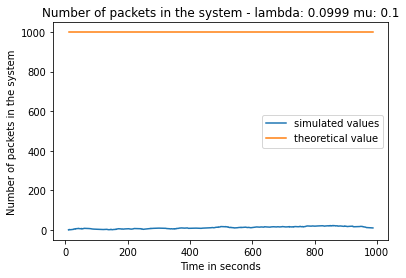

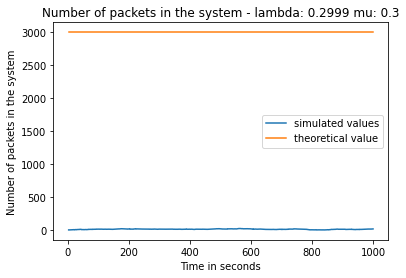

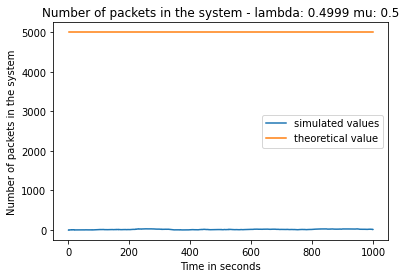

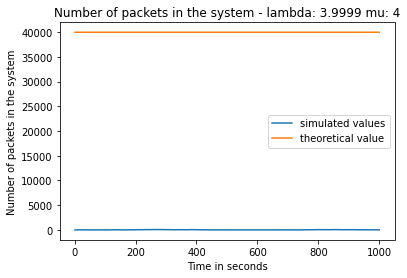

In [13]:
plot_simulation(0.0999, 0.1, 1000)
plot_simulation(0.2999, 0.3, 1000)
plot_simulation(0.4999, 0.5, 1000)
plot_simulation(3.9999, 4, 1000)

Let's define some functions that will be useful later on to compute mean, standard deviation and confidence interval for the mean of some data.

In [14]:
from math import sqrt

def compute_mean(values):
    tot = 0
    for i in values:
        tot += i
    return tot / len(values)

def compute_std_dev(values):
    mean = compute_mean(values)
    tot = 0
    for i in values:
        tot += (i - mean) ** 2
    return sqrt(tot / len(values))

def mean_interval(data, gamma):
    eta = None
    if gamma == 0.95:
        eta = 1.960
    elif gamma == 0.99:
        eta = 2.576
    else:
        # in these excercises we are only interested in 95% and 99% confidence
        pass
    mean = compute_mean(data)
    std_dev = compute_std_dev(data)
    incr = eta * std_dev / sqrt(len(data))
    return mean - incr, mean + incr

The following function runs a simulation and calculates the average time that a packet has to wait in the queue, plots the total waits for the packets and the theoretical value.

In [15]:
def calc_simulation_wait(lmbda, mu, max_time):
    q = simulate(lmbda, max_time)
    s = Server()
    packet_time, packet_status, packet_wait = manage_packets(q, s, mu)

    p = lmbda / mu
    theory_val = p**2 / (lmbda * (1-p))
    theoretical = [theory_val] * len(packet_wait)

    mean_wait = compute_mean(packet_wait)
    low, up = mean_interval(packet_wait, 0.95)

    print("Lambda: {}, Mu: {}".format(lmbda, mu))
    print("Simulated mean time in queue: {:0.3f}".format(mean_wait))
    print("95% C.I. for the mean: [{:0.3f}, {:0.3f}]".format(low, up))
    print("Theoretical mean time in queue: {:0.3f}".format(theory_val))

    plt.plot(packet_wait)
    plt.plot(theoretical)

    plt.xlabel('Time in seconds')
    plt.ylabel('Queue waiting time')
    plt.legend(['simulated values', 'theoretical value'])
    plt.title('Queue waiting time - lambda: {} mu: {}'.format(lmbda, mu))

    plt.show()

Running a simulation with stationary conditions, leads to a plot where the theoretical mean of the packets waiting in the queue doesn't fall inside the 95% Confidence Interval of the simulated mean.
Anyway, the value is sufficiently close to the simulated one, considering the variation of the simulated mean every time we re-run the simulation.

Lambda: 0.5, Mu: 0.6
Simulated mean time in queue: 11.655
95% C.I. for the mean: [10.711, 12.598]
Theoretical mean time in queue: 8.333


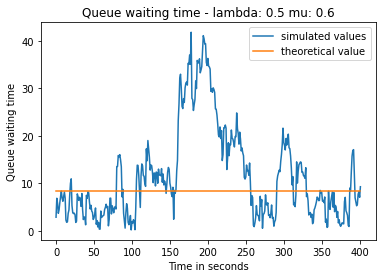

In [16]:
calc_simulation_wait(0.5, 0.6, 1000)

When we set a lambda slighly higher than the mu, our system seems to alternate transient and steady-state system condition. In fact, since $\lambda > \mu$, the system isn't in stationary conditions and it alternates times where the server is able to manage the packets, and times where there are packets waiting to be processed by the server.

Lambda: 0.1, Mu: 0.099
Simulated mean time in queue: 8.980
95% C.I. for the mean: [5.006, 12.954]
Theoretical mean time in queue: -1010.101


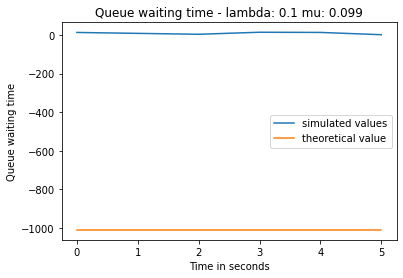

Lambda: 0.2, Mu: 0.199
Simulated mean time in queue: 16.033
95% C.I. for the mean: [13.292, 18.773]
Theoretical mean time in queue: -1005.025


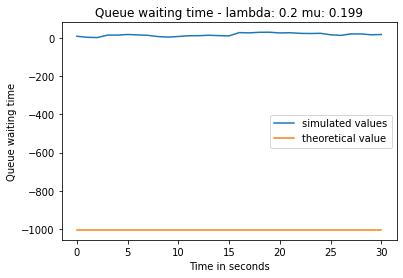

In [34]:
calc_simulation_wait(0.1, 0.099, 200)
calc_simulation_wait(0.2, 0.199, 200)

With the following function we can plot the empirical distribution of the number of packets in the system and of the queue waiting time running se simulation 2000 times and averaging the results.

In [18]:
def plot_distribution(lmbda, mu, max_time):
    values_ps = []
    values_pw = []
    for i in range(2000):
        q = simulate(lmbda, max_time)
        s = Server()
        packet_time, packet_status, packet_wait = manage_packets(q, s, mu)
        values_ps.append(compute_mean(packet_status))
        values_pw.append(compute_mean(packet_wait))

    plt.hist(values_ps, bins=50)

    plt.title('Packet in the system distribution - lambda: {} mu: {}'.format(lmbda, mu))

    plt.show()

    plt.hist(values_pw, bins=50)

    plt.title('Queue waiting time distribution - lambda: {} mu: {}'.format(lmbda, mu))

    plt.show()

Analysing the following plots, it can be noticed that the empirical distribution of the number of packets in the system and the one describing the queue waiting time, seems to behaves in more or less the same way keeping the same parameters.

We can analyze the three following cases:
- $\lambda = \mu + \epsilon$, so when lambda is slightly higher than mu. The distribustion seems to behave like a Lognomial one.
- $\lambda > \mu$. The system is far from the stationary conditions and the distribustion looks like a Gaussian.
- $\lambda < \mu$. The system is in stationary conditions and the distribution seems to be a Logistic distribution, so with less likelihood to the outliers.

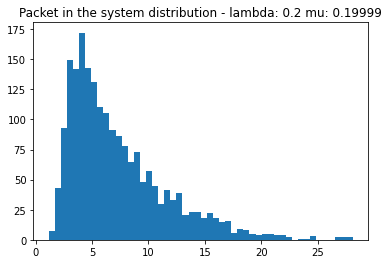

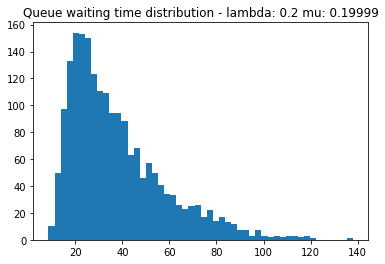

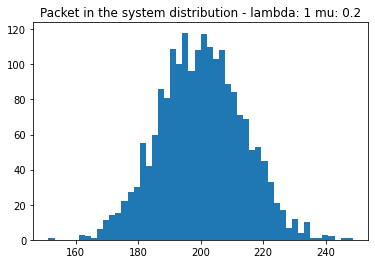

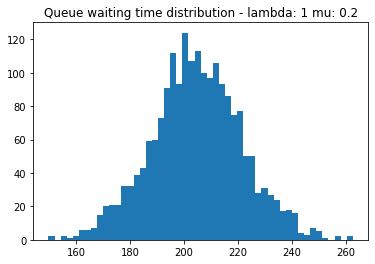

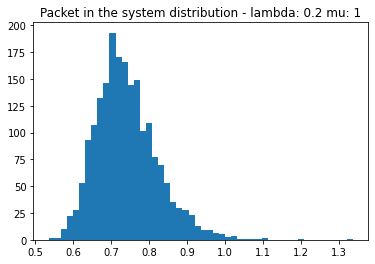

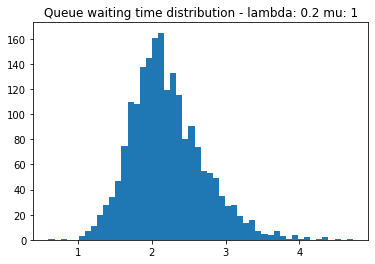

In [19]:
plot_distribution(0.2, 0.19999, 500)
plot_distribution(1, 0.2, 500)
plot_distribution(0.2, 1, 500)

## Exercise 2

Firstly, we need to modify the Event class previously defined in order to store the server which has elaborated the packet.

In [20]:
class Event:
    def __init__(self, occ_time, event_type:EventTypes):
        self.occurrence_time = occ_time
        self.event_type = event_type
        self.server_idx = None
        self.next_event = None

The following is a function capable to manage a queue of events and assign every packet to a server, giving priority to the one with a lower ID number.

To avoid editing the previous Server class, we decided to use the queue of the first Server as the global packet queue of the system.

In [21]:
def manage_packets_MMc(q, servers, server_lambda):
    packet_served = [0] * len(servers)
    while True:
        event = q.pop()
        if event.event_type == EventTypes.start_simulation:
            pass
        elif event.event_type == EventTypes.packet_arrival:
            found = False
            for s in range(len(servers)):
                if servers[s].server_status == 0:  # server free
                    servers[s].server_status = 1
                    leave_int = exponential_val(server_lambda)
                    e = Event(event.occurrence_time + leave_int, EventTypes.packet_departure)
                    e.server_idx = s
                    packet_served[s] += 1
                    q.insert_event(e)
                    found = True
                    break
            if not found:  # all servers are busy
                servers[0].queue.append(event)  # use only the queue of the first server for simplicity
        elif event.event_type == EventTypes.packet_departure:
            servers[event.server_idx].server_status = 0
            if len(servers[0].queue):  # schedule next departure event
                for s in range(len(servers)):
                    if servers[s].server_status == 0:  # server free
                        servers[s].server_status = 1
                        leave_int = exponential_val(server_lambda)
                        e = Event(event.occurrence_time + leave_int, EventTypes.packet_departure)
                        e.server_idx = s
                        packet_served[s] += 1
                        q.insert_event(e)

                        servers[0].queue = servers[0].queue[1:]  # remove first packet from the queue
                        break
        elif event.event_type == EventTypes.debug:
            print("debug")
        elif event.event_type == EventTypes.end_simulation:
            break

    return packet_served

Now, let's define a function to simulate a M/M/c system and plot the load of every server.

In [22]:
def simulate_MMc(lmbda, mu, max_time, c):
    q = simulate(lmbda, max_time)
    s = []
    for i in range(c):
        s.append(Server())
    packet_served = manage_packets_MMc(q, s, mu)

    plt.bar(range(c), packet_served)

    plt.title('Packet served by each server - lambda: {} mu: {}'.format(lmbda, mu))

    plt.show()

Simulating the M/M/c system with 2 or 3 servers and different mu, we can observe that the first server always manage a lot of more packets than the second one. Same for the second Server with respect to the third one.

Because of the loading plocy, the lower the server ID, the higher the number of packets managed by it.

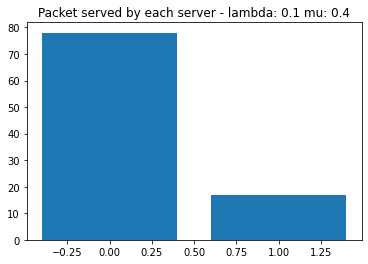

In [23]:
simulate_MMc(0.1, 0.4, 1000, 2)

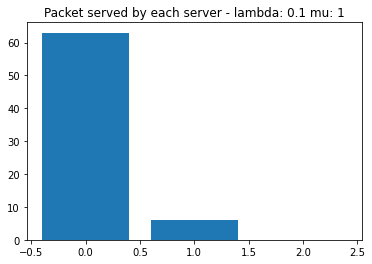

In [24]:
simulate_MMc(0.1, 1, 1000, 3)

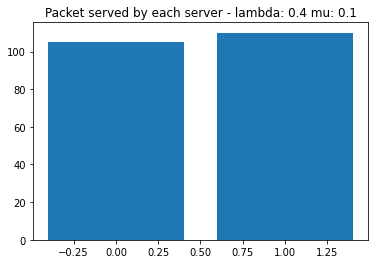

In [25]:
simulate_MMc(0.4, 0.1, 1000, 2)

To fix the previous problem we have to implement a load balancer. To do this, we sample from a uniform distribution using the method `randrange`. In this way, we choose which server will manage the packet simply choosing from the free servers using a uniform distribution.

In [26]:
def get_server_balanced(servers):
    free_srv = []
    for s in range(len(servers)):
        if servers[s].server_status == 0:
            free_srv.append(s)

    if len(free_srv) == 0:
        return None
    srv = rnd.randrange(0, len(free_srv))
    return free_srv[srv]

def manage_packets_MMc_balanced(q, servers, server_lambda):
    packet_served = [0] * len(servers)
    while True:
        event = q.pop()
        if event.event_type == EventTypes.start_simulation:
            pass
        elif event.event_type == EventTypes.packet_arrival:
            s = get_server_balanced(servers)

            if s is None:  # all servers are busy
                servers[0].queue.append(event)  # use only the queue of the first server for simplicity
            else:
                servers[s].server_status = 1
                leave_int = exponential_val(server_lambda)
                e = Event(event.occurrence_time + leave_int, EventTypes.packet_departure)
                e.server_idx = s
                packet_served[s] += 1
                q.insert_event(e)
        elif event.event_type == EventTypes.packet_departure:
            servers[event.server_idx].server_status = 0
            if len(servers[0].queue):  # schedule next departure event
                s = get_server_balanced(servers)
                servers[s].server_status = 1
                leave_int = exponential_val(server_lambda)
                e = Event(event.occurrence_time + leave_int, EventTypes.packet_departure)
                e.server_idx = s
                packet_served[s] += 1
                q.insert_event(e)

                servers[0].queue = servers[0].queue[1:]  # remove first packet from the queue
        elif event.event_type == EventTypes.debug:
            print("debug")
        elif event.event_type == EventTypes.end_simulation:
            break

    return packet_served

In [27]:
def simulate_MMc_balanced(lmbda, mu, max_time, c):
    q = simulate(lmbda, max_time)
    s = []
    for i in range(c):
        s.append(Server())
    packet_served = manage_packets_MMc_balanced(q, s, mu)

    plt.bar(range(c), packet_served)

    plt.title('Packet served by each server balanced - lambda: {} mu: {}'.format(lmbda, mu))

    plt.show()

As can be seen from the following plots, with the load balancer implemented above, with different values of lambda and mu, the number of packets managed by each server is more or less always the same.

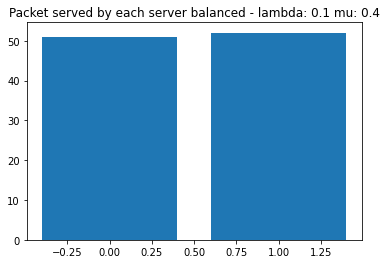

In [28]:
simulate_MMc_balanced(0.1, 0.4, 1000, 2)

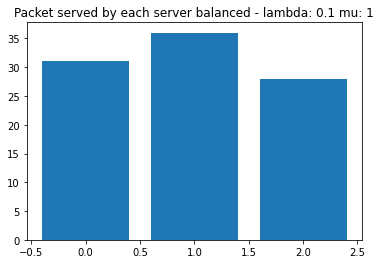

In [29]:
simulate_MMc_balanced(0.1, 1, 1000, 3)

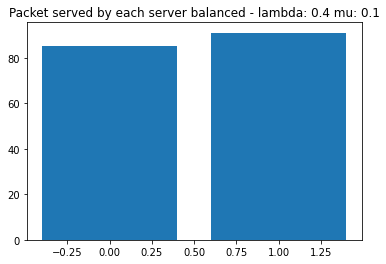

In [30]:
simulate_MMc_balanced(0.4, 0.1, 1000, 2)


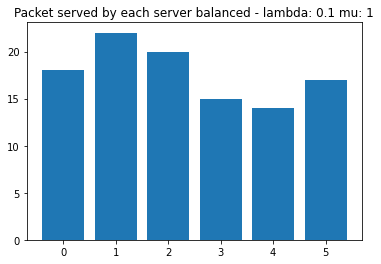

In [31]:

simulate_MMc_balanced(0.1, 1, 1000, 6)

## Exercise 3

In [1]:
from random import uniform
from math import sqrt
from queue import PriorityQueue

In [2]:
def euclidean_distance(a, b):
    return sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

In [3]:
class EventHandler:
    def __init__(self):
        self.events = PriorityQueue()
        
    def addEvent(self, e):
        self.events.put(e)
    
    def getEvent(self):
        return self.events.get()
    
    def isEmpty(self):
        return self.events.empty()

In [4]:
class Node:
    def __init__(self, maxX, maxY, minS, maxS):
        self.maxX = maxX
        self.maxY = maxY
        self.maxS = maxS
        self.minS = minS
        self.last_waypoint = -1
        self.getNewCoords()
        self.getNewWaypoint()
        self.getNewSpeed()
        
    def getNewCoords(self):
        self.x = uniform(0, self.maxX)
        self.y = uniform(0, self.maxY)
        
    def getNewWaypoint(self):
        self.next_waypoint_x = uniform(0, self.maxX)
        self.next_waypoint_y = uniform(0, self.maxY)
        
    def getNewSpeed(self):
        self.speed = uniform(self.minS, self.maxS)
        
    def getTimeNeeded(self):
        d = euclidean_distance((self.x, self.y), (self.next_waypoint_x, self.next_waypoint_y))
        return d / self.speed
    
    def arrived(self):
        self.x = self.next_waypoint_x
        self.y = self.next_waypoint_y
        self.getNewWaypoint()
        self.getNewSpeed()

In [5]:
class Simulation:
    def __init__(self, N, maxX, maxY, minS, maxS, time_measure):
        self.events = EventHandler()
        self.N = N
        self.maxX = maxX
        self.maxY = maxY
        self.maxS = maxS
        self.minS = minS
        self.time_measure = time_measure
        self.nodes = []
        self.events.addEvent((0, "init", -1))
        
    def init_event_handler(self):
        for n in range(self.N):
            self.nodes.append(Node(self.maxX, self.maxY, self.maxS, self.minS))
            self.events.addEvent((self.nodes[n].getTimeNeeded(), "waypoint_reached", n))
            
        self.events.addEvent((self.time_measure, 'measure_speed', -1))
        self.events.addEvent((9000, 'stop', -1))
                              
    def measure_speed(self, t):
        s = 0
        for node in self.nodes:
            s += node.speed
            
        self.events.addEvent((t + self.time_measure, 'measure_speed', -1))
        return s / self.N
    
    def waypoint_reached(self, i, t):
        self.nodes[i].arrived()
        self.events.addEvent((t + self.nodes[i].getTimeNeeded(), "waypoint_reached", i))
        
    def simulate(self):
        t = 0
        measures = []
        while True:
            event_time, event_type, event_node = self.events.getEvent()
            t = event_time
            if event_type == 'measure_speed':
                avg_speed = self.measure_speed(t)
                measures.append(avg_speed)
            elif event_type == 'init':
                self.init_event_handler()
            elif event_type == 'stop':
                break
            else:
                self.waypoint_reached(event_node, t)
        
        self.measures = measures
    
    def plot(self):
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10,5))
        plt.plot(self.measures)
        plt.show()

In [6]:
def run_set(N_sim, v_min):
    import numpy as np
    measures = None

    for i in range(N_sim):
        sim = Simulation(1, 100, 100, v_min, 10, 50)
        sim.simulate()
        m = np.array(sim.measures)
        
        if measures is None:
            measures = m
        else:
            measures += m

    measures /= N_sim
    return measures

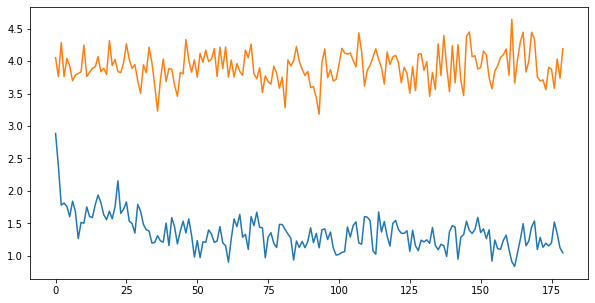

In [9]:
def compare():
    def plot(measures0, measures1):
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10,5))
        plt.plot(measures0, label='v_max [0, 10]')
        plt.plot(measures1, label='v_max [1, 10]')
        plt.show()
    
    measures0 = run_set(100, 0)
    measures1 = run_set(100, 1)
    plot(measures0, measures1)
    
compare()

https://www.netlab.tkk.fi/~esa/java/rwp/rwp-model.shtml

http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.12.9474&rep=rep1&type=pdf